In [1]:
import torch
import torch.nn as nn
import plotly.express as ex
import matplotlib.pyplot as plt

In [2]:
" Model Config "

vocab_size = -1
emb_dim = 3
block_size = 10
# torch.set_default_device("cuda:0")

In [3]:
with open("/Users/RootCl/Downloads/Datasets/wiki1m_for_simcse.txt") as f:
    db = f.read()
with open("./cache.txt" ,"w") as f:
    f.write(db[:10000])
del(db)

In [4]:
with open("./cache.txt") as f:
    db = f.read()

vocab = sorted(set(db))
vocab_size = len(vocab)

itos = { i:j for i,j in enumerate(vocab)}
stoi = { j:i for i,j in enumerate(vocab)}

encode = lambda x: [itos[i] for i in x]
decode = lambda x: [stoi[i] for i in x]

print(len(db))
print(vocab_size)
encode([1,2,3,4,5,6,7,8,9,0])

10000
75


[' ', '"', '&', "'", '(', ')', ',', '-', '.', '\n']

In [5]:
embeding = nn.Embedding( vocab_size , embedding_dim=2 )

In [6]:
embeding(torch.tensor([decode(list("hello"))]))

tensor([[[ 0.7957,  0.1967],
         [ 1.1221, -0.6298],
         [ 1.1362,  0.8775],
         [ 1.1362,  0.8775],
         [-1.4014,  0.1239]]], grad_fn=<EmbeddingBackward0>)

In [7]:
n = int(.9 * len(db))
db = torch.tensor(decode(db))
train = db[:n]
val = db[n:]
len(train),len(val)

(9000, 1000)

In [8]:
block_size = 10
x = train[:block_size]
y = train[1:block_size+1]

for i in range(block_size):
    print( x[:i+1] , "target =" , y[i])

tensor([43]) target = tensor(33)
tensor([43, 33]) target = tensor(23)
tensor([43, 33, 23]) target = tensor(21)
tensor([43, 33, 23, 21]) target = tensor(1)
tensor([43, 33, 23, 21,  1]) target = tensor(53)
tensor([43, 33, 23, 21,  1, 53]) target = tensor(58)
tensor([43, 33, 23, 21,  1, 53, 58]) target = tensor(1)
tensor([43, 33, 23, 21,  1, 53, 58,  1]) target = tensor(38)
tensor([43, 33, 23, 21,  1, 53, 58,  1, 38]) target = tensor(59)
tensor([43, 33, 23, 21,  1, 53, 58,  1, 38, 59]) target = tensor(65)


In [9]:
# -------------------------------------------------------

block_size = 100 # t
batch_size = 5  # b

def get_batch(split = 'train') -> torch.Tensor:
    data = train if split!='val' else val
    l = len(data) - block_size
    ix = torch.randint(l,( batch_size ,))
    for k,i in enumerate(ix):
        if data[i] != 0 and i< l-10:
            for j in range(10):
                if data[j] == 0:
                    ix[k] += j
                    break
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x,y


xb , yb = get_batch() # b , t
print( "\n\n".join([ "".join(encode(i)) for i in xb.tolist()]))

r.
The YMCA provided comfort, counselling and recreation to the troops.
YMCA war services were funde

," a large block of land in the lovely Mount Lofty Ranges, was purchased with swimming pool, tennis 

 exclusive and counterproductive.
He went on to build up World Vision Australia and then to New York

g and choral societies, a gymnasium, camps and an employment and immigration department.
Virgo was p

nt in Adelaide's religious life and conducted evangelistic services on Sunday evenings at the Theatr


In [10]:
class Head(nn.Module):

    def __init__(self , emb_dim , head_dim):
        super().__init__()
        self.emb_dim = emb_dim
        self.head_dim = head_dim
        self.xk = nn.Linear( emb_dim , head_dim , bias=False)
        self.xq = nn.Linear( emb_dim , head_dim , bias=False)
        self.xv = nn.Linear( emb_dim , head_dim , bias=False)
        self.register_buffer('tril', torch.tril( torch.ones(block_size,block_size)))
    
    def forward(self , idx):
        b , t , c = idx.shape
        k = self.xk(idx)
        q = self.xq(idx)
        v = self.xv(idx)
        wei = q @ k.transpose(-1,-2) * c **-0.5
        wei = wei.masked_fill(self.tril[:t,:t]==0, float("-inf"))
        wei = nn.functional.softmax(wei, dim=-1)
        out = wei @ v
        return out

h = Head( 20 , 16 )
h( torch.randn(1,3,20) ).shape

torch.Size([1, 3, 16])

In [166]:
class Transformer(nn.Module):

    def __init__(self , vocab_size , emb_dim , head_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.head_dim = head_dim
        self.token = nn.Embedding( self.vocab_size , emb_dim )
        self.sa = Head(emb_dim , head_dim)
        self.ff = nn.Linear(head_dim , self.vocab_size)
        self.sa2 = Head(self.vocab_size , head_dim)
        self.ff2 = nn.Linear(head_dim , self.vocab_size)
        
    
    def forward(self , x , y = None):
        logits = self.token(x)#  x ( b , t ) , ( b , t , c )  #  b , t , head_dim
        logits = self.ff(self.sa(logits))
        logits = self.ff2(self.sa2(logits))
        if y==None:
            loss = None
        else:
            b , t , c = logits.shape
            logits = logits.view( b*t , c )
            y = y.view( b*t )
            loss = nn.functional.cross_entropy(logits,y)
        return logits , loss
        
    def generate(self,x, max_predictions):
        for _ in range(max_predictions):
            idx = x[:, -block_size:]
            logits , loss = self(idx)
            logits = logits[: , -1 ,:]
            
            prob = nn.functional.softmax(logits , dim=-1)
            
            x_next = torch.multinomial(prob ,1)
            
            x = torch.cat((x,x_next),dim=1)
        return x

model = Transformer( vocab_size , emb_dim = 64, head_dim = 32)

In [138]:
print("".join(encode(model.generate(xb , vocab_size)[1].tolist())))

some of the state's leading influential figures to its board and men of high calibre as General Secr4YvN,m£8Uf&RgK3MJckdq₤EDa£y0-8yE/l£6iv9JbL rgpu-37 tdu)0kiZ4M1wIT9D2'i£Oel.


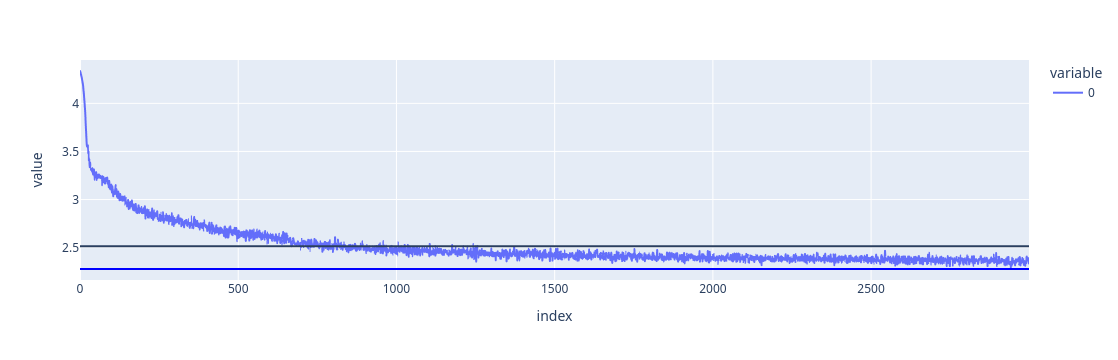

In [167]:
batch_size = 32
optim = torch.optim.AdamW(model.parameters() , lr=1e-3)
_loss = []
times = range(3000)
for i in times:
    xb , xy = get_batch('train')
    optim.zero_grad()
    logits , loss = model(xb,xy)
    loss.backward()
    optim.step()
    _loss.append(loss.item())

ex.line(_loss , labels={ 'x'}).add_hline(sum(_loss)/len(_loss)).add_hline(min(_loss) ,line_color="blue")

In [172]:
 print("".join(encode(model.generate(xb , 100)[0].tolist())))

A war services were funded by public donation and during this time in South Australia ₤199,185 was re ais the imeglathen 191850 rare tr ch oplethe stinemin hunthinalo onscis is.
See hionts teal Es fof


In [15]:
print(vocab_size)

75
